# Credit Card Fraud Detection

## Overview

<div style="font-size:large;font-weight:500">Problem</div>
<div style="text-align:justify">Although fraudulent transactions make up a small percentage of total credit card transactions, these transactions cause financial loss to cardholders and may proliferate if left unchecked.</div>
<br/>
<div style="font-size:large;font-weight:500">Context</div>
<div style="text-align:justify">
(<i>From Kaggle</i>)
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.<br/>
(<i><b>Reference:</b> <a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud">https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud</a></i>)</div>
<br/>
<div style="font-size:large;font-weight:500">Objective</div>
<div style="text-align:justify">The objective of this analysis is to find an appropriate data model to correctly determine if a credit card transaction is fraudulent.</div>
<br/>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import copy as cp
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import metrics

from scipy import stats
from datetime import datetime
from imblearn.over_sampling import SMOTE
from itertools import chain, combinations
from pathlib import Path
from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
def load_data():
    df = pd.read_csv('./data/cc-fraud-detect.csv', header=0)
    return df

In [5]:
def start_timing():
    dt_start = datetime.now()
    print("\nStart:", dt_start)
    return dt_start

In [6]:
def show_duration(start):
    duration = datetime.now() - start
    print('Duration: {0}'.format(duration))

In [7]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

## Exploratory Data Analysis (EDA)
A quick glance at the data shows all features have already been encoded into numerals and there are no null values. Except 'Time' and 'Amount', all other features are unlabeled.

In [8]:
df_fraud = load_data()
df_fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<div class="alert alert-block alert-info" style="text-align:justify">
<i><b>Commentary: </b>Target variable 'Class' is highly imbalanced as briefed.</i>
</div>

In [10]:
df_fraud[['Class']].value_counts()

Class
0        284315
1           492
dtype: int64

<div class="alert alert-block alert-info" style="text-align:justify">
<i><b>Commentary: </b>The description of the dataframe shows that the range of the unlabeled features are quite similar to one another. From the boxplot of unlabeled features, we are able to spot a few features with obvious outliers.</i>
</div>

In [11]:
df_fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392460e-15,-7.466538e-16,4.258754e-16,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


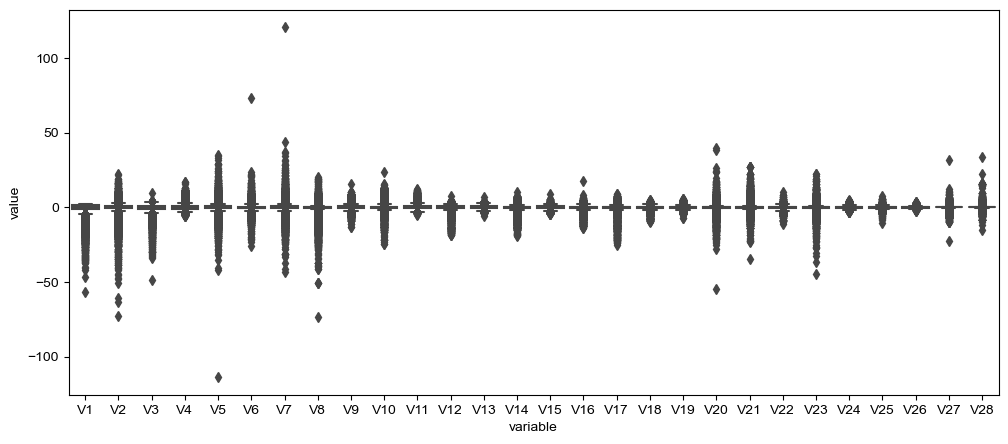

In [12]:
df_boxplot = df_fraud.drop(['Class','Time','Amount'], axis=1)
df_boxplot = pd.melt(df_boxplot)
fig, ax = plt.subplots(figsize=(12, 5))
sns.set_style('darkgrid')
sns.boxplot(x='variable', y='value', data=df_boxplot, ax=ax)
plt.show()

<div class="alert alert-block alert-info" style="text-align:justify">
<i><b>Commentary: </b>Running the data through a quick Logistic Regression model, we find that the model gives an F1 score of ~0.6 before feature selection and tuning.</i>
</div>

In [13]:
# Logistic Regression, Train-Test-Split
# All Features - Precision, Recall & F1 Score

# Performance Tracking
dt_start = start_timing()

# Initialise Parameters
all_features = df_fraud.columns.values.tolist()
all_features.remove('Class')
tts_train_size = 0.8
tts_test_size = 1 - tts_train_size

# Prep Test & Train Data
X = df_fraud[all_features]
y = df_fraud[['Class']]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = tts_train_size, test_size = tts_test_size)
logreg = LogisticRegression(n_jobs=10)
logreg.fit(X_train, y_train.values.ravel())
y_pred = logreg.predict(X_test)

print('Logistic Regression - Precision = {0:0.4f}'.format(metrics.precision_score(y_test, y_pred)))
print('Logistic Regression - Recall = {0:0.4f}'.format(metrics.recall_score(y_test, y_pred)))
print('Logistic Regression - F1 Score = {0:0.4f}'.format(metrics.f1_score(y_test, y_pred)))

# Performance Tracking
show_duration(dt_start)


Start: 2023-02-19 15:07:08.746650
Logistic Regression - Precision = 0.7339
Logistic Regression - Recall = 0.6780
Logistic Regression - F1 Score = 0.7048
Duration: 0:00:03.966108


## Feature Engineering

### Removing Outliers with Z-Score
It appears Logistic Regression gives a decent Precision and Recall score even before optimization and tuning. We will now prepare the data with Logistic Regression as the target model to use for prediction. As the data is already numerically encoded, we will only remove the outliers from the features.

In [14]:
for c in range(1, 29):
    df_fraud['V{0}_zscore'.format(c)] = (df_fraud['V{0}'.format(c)] - df_fraud['V{0}'.format(c)].mean())/df_fraud['V{0}'.format(c)].std(ddof=0)
df_fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,V1_zscore,V2_zscore,V3_zscore,V4_zscore,V5_zscore,V6_zscore,V7_zscore,V8_zscore,V9_zscore,V10_zscore,V11_zscore,V12_zscore,V13_zscore,V14_zscore,V15_zscore,V16_zscore,V17_zscore,V18_zscore,V19_zscore,V20_zscore,V21_zscore,V22_zscore,V23_zscore,V24_zscore,V25_zscore,V26_zscore,V27_zscore,V28_zscore
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392460e-15,-7.466538e-16,4.258754e-16,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727,-2.256785e-15,-1.712391e-16,1.785957e-16,-1.289632e-15,1.580275e-15,-9.373260e-17,-4.945361e-17,3.577711e-17,1.066824e-15,4.528659e-16,2.441235e-15,2.514128e-15,-9.210239e-16,-1.012324e-15,-1.295226e-16,-9.856593e-17,1.199236e-15,3.188531e-16,-1.675353e-16,4.185621e-16,8.946451e-17,-3.516019e-16,-1.166010e-15,1.312707e-16,-2.510101e-15,2.030886e-16,-9.046096e-18,1.290217e-16
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,-2.258191e+01,-4.700128e+00,-1.869868e+01,-5.819392e+00,-2.004428e+01,-4.915191e+00,-1.612534e+01,-2.962645e+01,-1.133266e+01,-8.861402e+00,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,-4.69891

In [15]:
max_zscore = 3
for c in range(1, 29):
    print('V{0}_zscore'.format(c), df_fraud['V{0}_zscore'.format(c)][df_fraud['V{0}_zscore'.format(c)] > max_zscore].count())

V1_zscore 0
V2_zscore 1462
V3_zscore 1
V4_zscore 2853
V5_zscore 1384
V6_zscore 4042
V7_zscore 1433
V8_zscore 997
V9_zscore 2006
V10_zscore 2827
V11_zscore 582
V12_zscore 176
V13_zscore 783
V14_zscore 746
V15_zscore 206
V16_zscore 315
V17_zscore 2048
V18_zscore 566
V19_zscore 2235
V20_zscore 3111
V21_zscore 2425
V22_zscore 340
V23_zscore 1904
V24_zscore 125
V25_zscore 763
V26_zscore 995
V27_zscore 1770
V28_zscore 1031


In [16]:
max_zscore = 4
for c in range(1, 29):
    print('V{0}_zscore'.format(c), df_fraud['V{0}_zscore'.format(c)][df_fraud['V{0}_zscore'.format(c)] > max_zscore].count())

V1_zscore 0
V2_zscore 604
V3_zscore 1
V4_zscore 431
V5_zscore 671
V6_zscore 596
V7_zscore 771
V8_zscore 527
V9_zscore 939
V10_zscore 1789
V11_zscore 267
V12_zscore 29
V13_zscore 9
V14_zscore 292
V15_zscore 30
V16_zscore 100
V17_zscore 678
V18_zscore 45
V19_zscore 412
V20_zscore 1661
V21_zscore 1538
V22_zscore 129
V23_zscore 1117
V24_zscore 117
V25_zscore 182
V26_zscore 512
V27_zscore 1035
V28_zscore 599


<div class="alert alert-block alert-info" style="text-align:justify">
<i><b>Commentary: </b>Typically z-scores > 3 are considered outliers, but the number of z-scores > 3 are significant (~36K rows) so we will remove outliers with z-score > 4 (~13K rows) instead.</i>
</div>

In [17]:
max_zscore = 4
df_fraud = load_data()
v_features = df_fraud.columns.values.tolist()
v_features = [e for e in v_features if e not in ('Class','Time','Amount')]
df_fraud = df_fraud[(np.abs(stats.zscore(df_fraud[v_features])) < max_zscore).all(axis=1)]
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271202 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    271202 non-null  float64
 1   V1      271202 non-null  float64
 2   V2      271202 non-null  float64
 3   V3      271202 non-null  float64
 4   V4      271202 non-null  float64
 5   V5      271202 non-null  float64
 6   V6      271202 non-null  float64
 7   V7      271202 non-null  float64
 8   V8      271202 non-null  float64
 9   V9      271202 non-null  float64
 10  V10     271202 non-null  float64
 11  V11     271202 non-null  float64
 12  V12     271202 non-null  float64
 13  V13     271202 non-null  float64
 14  V14     271202 non-null  float64
 15  V15     271202 non-null  float64
 16  V16     271202 non-null  float64
 17  V17     271202 non-null  float64
 18  V18     271202 non-null  float64
 19  V19     271202 non-null  float64
 20  V20     271202 non-null  float64
 21  V21     27

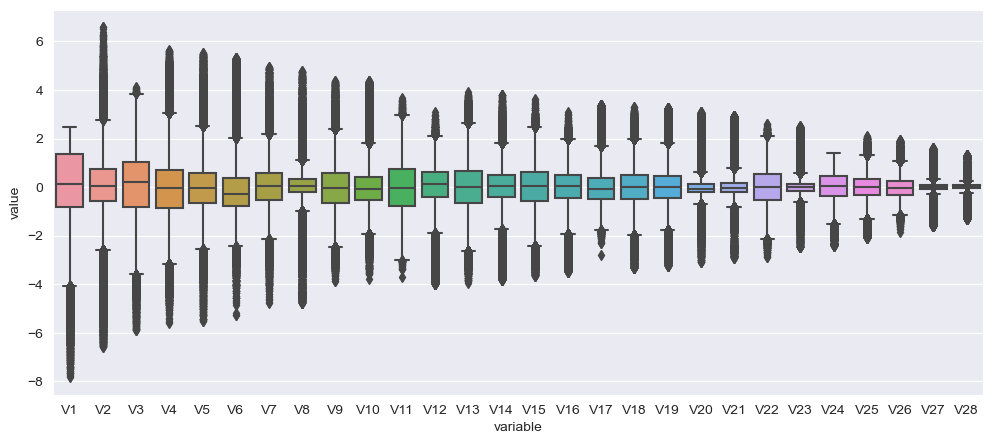

In [18]:
df_boxplot = df_fraud.drop(['Class','Time','Amount'], axis=1)
df_boxplot = pd.melt(df_boxplot)
fig, ax = plt.subplots(figsize=(12, 5))
sns.set_style('darkgrid')
sns.boxplot(x='variable', y='value', data=df_boxplot, ax=ax)
plt.show()

### Balancing Classification with SMOTE

In [19]:
all_features = df_fraud.columns.values.tolist()
all_features = [e for e in v_features if e not in ('Class')]
X = df_fraud[all_features]
y = df_fraud[['Class']]
smt = SMOTE()
X, y = smt.fit_resample(X, y)
y.value_counts()

Class
0        271136
1        271136
dtype: int64

## Feature Selection

### ANOVA
Finding the combination of features that gives the best precision/recall scores. Inputs=Numerical & Output=Categorical -> ANOVA for feature selection.

In [20]:
# Select top 10 features
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y.values.ravel())
col_indexes = selector.get_support(indices=True)
X_best_10 = X.iloc[:, col_indexes]

# Select top 15 features
selector = SelectKBest(f_classif, k=15)
selector.fit(X, y.values.ravel())
col_indexes = selector.get_support(indices=True)
X_best_15 = X.iloc[:, col_indexes]

# Select top 20 features
selector = SelectKBest(f_classif, k=20)
selector.fit(X, y.values.ravel())
col_indexes = selector.get_support(indices=True)
X_best_20 = X.iloc[:, col_indexes]

# Select top 25 features
selector = SelectKBest(f_classif, k=25)
selector.fit(X, y.values.ravel())
col_indexes = selector.get_support(indices=True)
X_best_25 = X.iloc[:, col_indexes]

## Data Modeling
The field of data science is maturing at an amazing pace with new machine learning models produced every few days. We will try two popular models for this showcase, the <b>Logistic Regression</b> and <b>Random Forest Classifier</b> models.

In [21]:
# Common Variables
class_labels = ["Legitimate", "Fraudulent"]
skf = StratifiedKFold(n_splits = 5)

In [22]:
def cross_val_predict(model, skf:StratifiedKFold, X:np.array, y:np.array) -> tuple[np.array, np.array, np.array]:
    model_ = cp.deepcopy(model)    
    no_classes = len(np.unique(y))    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes])
    
    for train_index, test_index in tqdm(skf.split(X, y), total=skf.get_n_splits()):
        X_train_kf, X_test_kf = X[train_index], X[test_index]
        y_train_kf, y_test_kf = y[train_index], y[test_index]
        actual_classes = np.append(actual_classes, y_test_kf)
        model_.fit(X_train_kf, y_train_kf)
        predicted_classes = np.append(predicted_classes, model_.predict(X_test_kf))
        
        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(X_test_kf), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(X_test_kf), no_classes), dtype=float), axis=0)
    
    return actual_classes, predicted_classes, predicted_proba

In [23]:
def plot_confusion_matrix(actual_classes:np.array, predicted_classes:np.array, sorted_labels:list):
    cnf_matrix = metrics.confusion_matrix(actual_classes, predicted_classes)
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues" ,fmt='g')
    ax.xaxis.set_label_position("bottom")
    ax.yaxis.set_label_position("left")
    plt.tight_layout()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()    

### Logistic Regression
The initial model based on Logistic Regression appears to give decent precision, recall & f1 scores of >0.7. A stratified 5-fold cross validation resulted in the mean precision dropping a little. Considering that we are trying to predict credit card fraud and cardholders' money is at stake, the model can perform better. We will also try to base predictions on the random forest classification model for comparison.

In [24]:
# Logistic Regression, Stratified K-Fold Cross Validation
# Runtime ~1m

# Logistic Regression with best 10 features
dt_start = start_timing()
logreg = LogisticRegression(n_jobs=10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(logreg, skf, X_best_10.to_numpy(), y.to_numpy())
print("Classification Report for Logistic Regression (Best 10 Features)")
print("----------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
show_duration(dt_start)

# Logistic Regression with best 15 features
dt_start = start_timing()
logreg = LogisticRegression(n_jobs=10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(logreg, skf, X_best_15.to_numpy(), y.to_numpy())
print("Classification Report for Logistic Regression (Best 15 Features)")
print("----------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
show_duration(dt_start)

# Logistic Regression with best 20 features
dt_start = start_timing()
logreg = LogisticRegression(n_jobs=10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(logreg, skf, X_best_20.to_numpy(), y.to_numpy())
print("Classification Report for Logistic Regression (Best 20 Features)")
print("----------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
show_duration(dt_start)

# Logistic Regression with best 25 features
dt_start = start_timing()
logreg = LogisticRegression(n_jobs=10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(logreg, skf, X_best_25.to_numpy(), y.to_numpy())
print("Classification Report for Logistic Regression (Best 25 Features)")
print("----------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
show_duration(dt_start)

# Logistic Regression with all features
dt_start = start_timing()
logreg = LogisticRegression(n_jobs=10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(logreg, skf, X.to_numpy(), y.to_numpy())
print("Classification Report for Logistic Regression (All Features)")
print("----------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
show_duration(dt_start)


Start: 2023-02-19 15:07:19.029186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.05s/it]


Classification Report for Logistic Regression (Best 10 Features)
----------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     0.8590    0.8507    0.8549    271136
  Fraudulent     0.8522    0.8604    0.8563    271136

    accuracy                         0.8556    542272
   macro avg     0.8556    0.8556    0.8556    542272
weighted avg     0.8556    0.8556    0.8556    542272

Duration: 0:00:05.774362

Start: 2023-02-19 15:07:24.803548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.46s/it]


Classification Report for Logistic Regression (Best 15 Features)
----------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     0.8554    0.8418    0.8486    271136
  Fraudulent     0.8443    0.8577    0.8510    271136

    accuracy                         0.8498    542272
   macro avg     0.8499    0.8498    0.8498    542272
weighted avg     0.8499    0.8498    0.8498    542272

Duration: 0:00:07.834951

Start: 2023-02-19 15:07:32.638499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.09s/it]


Classification Report for Logistic Regression (Best 20 Features)
----------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     0.8588    0.8488    0.8538    271136
  Fraudulent     0.8505    0.8604    0.8555    271136

    accuracy                         0.8546    542272
   macro avg     0.8547    0.8546    0.8546    542272
weighted avg     0.8547    0.8546    0.8546    542272

Duration: 0:00:10.970072

Start: 2023-02-19 15:07:43.608571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.33s/it]


Classification Report for Logistic Regression (Best 25 Features)
----------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     0.8810    0.8623    0.8715    271136
  Fraudulent     0.8652    0.8835    0.8742    271136

    accuracy                         0.8729    542272
   macro avg     0.8731    0.8729    0.8729    542272
weighted avg     0.8731    0.8729    0.8729    542272

Duration: 0:00:17.235122

Start: 2023-02-19 15:08:00.843693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.19s/it]


Classification Report for Logistic Regression (All Features)
----------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     0.8933    0.8689    0.8809    271136
  Fraudulent     0.8724    0.8962    0.8841    271136

    accuracy                         0.8826    542272
   macro avg     0.8828    0.8826    0.8825    542272
weighted avg     0.8828    0.8826    0.8825    542272

Duration: 0:00:21.460484


### Random Forest Classification
The results from using the random forest classification data model are impressive, boasting almost perfect precision, recall & F1 scores of ~1 even with a stratified 5-fold cross validation.

In [25]:
# Random Forest Classification, Stratified K-Fold Cross Validation
# Runtime ~23m

# Random Forest Classification with best 10 features
dt_start = start_timing()
rfc = RandomForestClassifier(n_jobs=10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(rfc, skf, X_best_10.to_numpy(), y.to_numpy())
print("Classification Report for Random Forest Classification (Best 10 Features)")
print("-------------------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
show_duration(dt_start)

# Random Forest Classification with best 15 features
dt_start = start_timing()
rfc = RandomForestClassifier(n_jobs=10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(rfc, skf, X_best_15.to_numpy(), y.to_numpy())
print("Classification Report for Random Forest Classification (Best 15 Features)")
print("-------------------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
show_duration(dt_start)

# Random Forest Classification with best 20 features
dt_start = start_timing()
rfc = RandomForestClassifier(n_jobs=10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(rfc, skf, X_best_20.to_numpy(), y.to_numpy())
print("Classification Report for Random Forest Classification (Best 20 Features)")
print("-------------------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
show_duration(dt_start)

# Random Forest Classification with best 25 features
dt_start = start_timing()
rfc = RandomForestClassifier(n_jobs=10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(rfc, skf, X_best_25.to_numpy(), y.to_numpy())
print("Classification Report for Random Forest Classification (Best 25 Features)")
print("-------------------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
show_duration(dt_start)

# Random Forest Classification with all features
dt_start = start_timing()
rfc = RandomForestClassifier(n_jobs=10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(rfc, skf, X.to_numpy(), y.to_numpy())
print("Classification Report for Random Forest Classification (All Features)")
print("-------------------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
show_duration(dt_start)


Start: 2023-02-19 15:08:22.327366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:40<00:00, 32.12s/it]


Classification Report for Random Forest Classification (Best 10 Features)
-------------------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     1.0000    0.9994    0.9997    271136
  Fraudulent     0.9994    1.0000    0.9997    271136

    accuracy                         0.9997    542272
   macro avg     0.9997    0.9997    0.9997    542272
weighted avg     0.9997    0.9997    0.9997    542272

Duration: 0:02:41.084867

Start: 2023-02-19 15:11:03.412233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.38s/it]


Classification Report for Random Forest Classification (Best 15 Features)
-------------------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     1.0000    0.9997    0.9998    271136
  Fraudulent     0.9997    1.0000    0.9998    271136

    accuracy                         0.9998    542272
   macro avg     0.9998    0.9998    0.9998    542272
weighted avg     0.9998    0.9998    0.9998    542272

Duration: 0:02:57.461086

Start: 2023-02-19 15:14:00.873319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:16<00:00, 51.32s/it]


Classification Report for Random Forest Classification (Best 20 Features)
-------------------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     1.0000    0.9997    0.9999    271136
  Fraudulent     0.9997    1.0000    0.9999    271136

    accuracy                         0.9999    542272
   macro avg     0.9999    0.9999    0.9999    542272
weighted avg     0.9999    0.9999    0.9999    542272

Duration: 0:04:17.075326

Start: 2023-02-19 15:18:17.948645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:44<00:00, 68.96s/it]


Classification Report for Random Forest Classification (Best 25 Features)
-------------------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     1.0000    0.9998    0.9999    271136
  Fraudulent     0.9998    1.0000    0.9999    271136

    accuracy                         0.9999    542272
   macro avg     0.9999    0.9999    0.9999    542272
weighted avg     0.9999    0.9999    0.9999    542272

Duration: 0:05:45.302137

Start: 2023-02-19 15:24:03.250782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:53<00:00, 70.72s/it]


Classification Report for Random Forest Classification (All Features)
-------------------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     1.0000    0.9998    0.9999    271136
  Fraudulent     0.9998    1.0000    0.9999    271136

    accuracy                         0.9999    542272
   macro avg     0.9999    0.9999    0.9999    542272
weighted avg     0.9999    0.9999    0.9999    542272

Duration: 0:05:54.098574


## Hyperparameter Tuning

### Logistic Regression
Metrics for the Logistic Regression model only saw a tiny improvement after hyperparameter tuning (precision 0.8724 -> 0.8778). The cost for this slight improvement is an increased training time (6x increase from 20s -> 2m) using liblinear as the solver. "Saga" is ruled out as an option because with a training time of 12m, we are better off using even the default RFC model.

In [26]:
# GridSearchCV Parameters
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
C = [0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2', 'elasticnet', None]

In [27]:
# Logistic Regression, GridSearchCV Hyperparameter Tuning
# Runtime ~1h

# Setup parameters
logreg = LogisticRegression(multi_class = 'ovr',
                            max_iter = 8000,
                            n_jobs = 10)
gs_params = {'solver': solver,             
             'C': C}

# Run GridSearchCV
dt_start = start_timing()
gs = GridSearchCV(estimator = logreg,  
                  param_grid = gs_params,
                  scoring = 'precision',
                  cv = skf,
                  verbose = 1,
                  n_jobs = 1)
gs.fit(X, y.values.ravel())
show_duration(dt_start)

# Show Results
df_cv_results = pd.DataFrame(gs.cv_results_)
df_cv_results.head()


Start: 2023-02-19 15:29:57.383883
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Duration: 1:09:29.531139


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.020837,0.714491,0.019935,0.006065,0.001,newton-cg,"{'C': 0.001, 'solver': 'newton-cg'}",0.854435,0.886732,0.883854,0.836179,0.854723,0.863184,0.019283,26
1,1.915036,0.039609,0.019055,0.006343,0.001,lbfgs,"{'C': 0.001, 'solver': 'lbfgs'}",0.854420,0.886730,0.883840,0.836193,0.854723,0.863181,0.019277,28
2,1.712150,0.028149,0.024959,0.007653,0.001,liblinear,"{'C': 0.001, 'solver': 'liblinear'}",0.851065,0.883907,0.881804,0.832649,0.851288,0.860143,0.019752,30
3,2.919226,0.229246,0.027791,0.005977,0.001,sag,"{'C': 0.001, 'solver': 'sag'}",0.854435,0.886734,0.883854,0.836164,0.854723,0.863182,0.019288,27
4,3.496164,0.269777,0.021699,0.007107,0.001,saga,"{'C': 0.001, 'solver': 'saga'}",0.854407,0.886732,0.883856,0.836164,0.854723,0.863176,0.019290,29


In [28]:
# Show top parameter settings
df_cv_results[['param_solver','param_C','mean_test_score','rank_test_score']].sort_values(by=['rank_test_score'], ascending=True).head()

,param_solver,param_C,mean_test_score,rank_test_score
24,saga,10,0.878074,1
23,sag,10,0.878063,2
22,liblinear,10,0.878047,3
20,newton-cg,10,0.878007,4
21,lbfgs,10,0.877998,5



Start: 2023-02-19 16:42:22.424976


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [12:36<00:00, 151.24s/it]


Classification Report for Logistic Regression (All Features, Post-Tuning)
-------------------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     0.9031    0.8738    0.8882    271136
  Fraudulent     0.8778    0.9063    0.8918    271136

    accuracy                         0.8901    542272
   macro avg     0.8905    0.8901    0.8900    542272
weighted avg     0.8905    0.8901    0.8900    542272



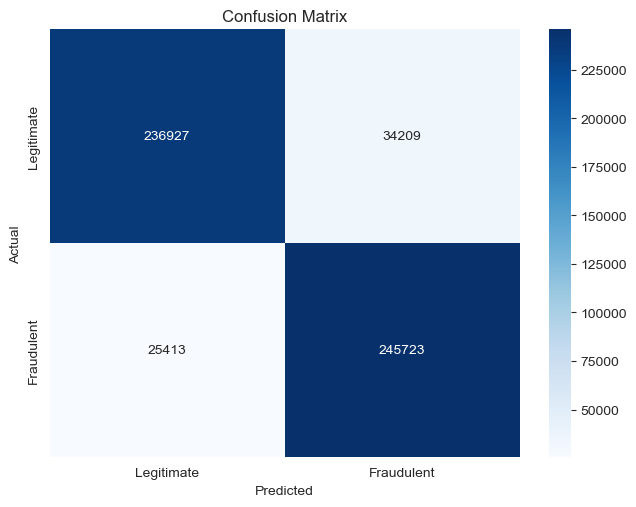

Duration: 0:12:36.890045


In [29]:
# Logistic Regression, Stratified K-Fold Cross Validation (Post-Tuning)
# Runtime ~15m

dt_start = start_timing()
logreg = LogisticRegression(solver = 'saga',
                            C = 10,
                            multi_class = 'ovr',
                            max_iter = 8000,
                            n_jobs = 10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(logreg, skf, X.to_numpy(), y.to_numpy())
print("Classification Report for Logistic Regression (All Features, Post-Tuning)")
print("-------------------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
plot_confusion_matrix(actual_classes, predicted_classes, class_labels)
show_duration(dt_start)


Start: 2023-02-19 16:55:08.902190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:59<00:00, 23.90s/it]


Classification Report for Logistic Regression (All Features, Post-Tuning)
-------------------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     0.9034    0.8738    0.8883    271136
  Fraudulent     0.8778    0.9066    0.8919    271136

    accuracy                         0.8902    542272
   macro avg     0.8906    0.8902    0.8901    542272
weighted avg     0.8906    0.8902    0.8901    542272



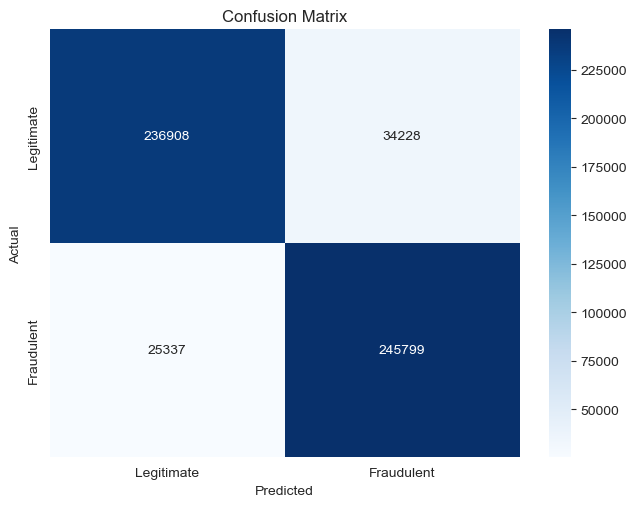

Duration: 0:02:00.205776


In [30]:
# Logistic Regression, Stratified K-Fold Cross Validation (Post-Tuning)
# Runtime ~2m

dt_start = start_timing()
logreg = LogisticRegression(solver = 'liblinear',
                            C = 10,
                            multi_class = 'ovr',
                            max_iter = 8000,
                            n_jobs = 10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(logreg, skf, X.to_numpy(), y.to_numpy())
print("Classification Report for Logistic Regression (All Features, Post-Tuning)")
print("-------------------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
plot_confusion_matrix(actual_classes, predicted_classes, class_labels)
show_duration(dt_start)

### Random Forest Classification
Even before hyperparameter tuning, prediction with an RFC model is already producing near perfect results. However the processing power and time taken to run RFC is significantly higher than when Logistic Regression is used. We will have to weigh the benefits against constraints to determine if RFC is a suitable model to be deployed. In a fast moving environment where multiple transactions are executed every second, it may be impractical to use the RFC for prediction despite its near perfect accuracy.

In [31]:
# GridSearchCV Parameters
n_estimators = [int(x) for x in np.linspace(start=100, stop=900, num=6)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num=10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [32]:
# Random Forest Classification, GridSearchCV Hyperparameter Tuning
# Runtime ~4.5h

# Setup parameters
rfc = RandomForestClassifier(n_jobs = 10)
gs_params = {'max_features': max_features,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap}

# Run GridSearchCV
dt_start = start_timing()
gs = GridSearchCV(estimator = rfc,  
                  param_grid = gs_params,
                  scoring = 'precision',
                  cv = skf,
                  verbose = 1,
                  n_jobs = 1)
gs.fit(X, y.values.ravel())
show_duration(dt_start)

# Show Results
df_cv_results = pd.DataFrame(gs.cv_results_)
df_cv_results.head()


Start: 2023-02-19 16:59:50.026493
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Duration: 4:21:52.812909


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,68.819113,0.800297,0.284146,0.003429,True,auto,1,2,"{'bootstrap': True, 'max_features': 'auto', 'm...",0.999779,0.999945,0.999889,0.999705,0.999816,0.999827,0.000084,15
1,68.936719,1.280871,0.286738,0.006501,True,auto,1,5,"{'bootstrap': True, 'max_features': 'auto', 'm...",0.999779,0.999963,0.999852,0.999723,0.999834,0.999830,0.000080,14
2,68.761745,0.789628,0.277029,0.007392,True,auto,1,10,"{'bootstrap': True, 'max_features': 'auto', 'm...",0.999723,0.999926,0.999945,0.999594,0.999834,0.999805,0.000131,22
3,66.898880,1.571905,0.280510,0.008678,True,auto,2,2,"{'bootstrap': True, 'max_features': 'auto', 'm...",0.999705,0.999963,0.999834,0.999668,0.999834,0.999801,0.000105,25
4,67.558214,0.479038,0.281379,0.001176,True,auto,2,5,"{'bootstrap': True, 'max_features': 'auto', 'm...",0.999760,0.999926,0.999889,0.999558,0.999816,0.999790,0.000130,27


In [33]:
# Show top parameter settings
df_cv_results[['param_max_features','param_min_samples_split','param_min_samples_leaf','param_bootstrap','mean_test_score','rank_test_score']].sort_values(by=['rank_test_score'], ascending=True).head()

,param_max_features,param_min_samples_split,param_min_samples_leaf,param_bootstrap,mean_test_score,rank_test_score
19,auto,5,1,False,0.999900,1
27,sqrt,2,1,False,0.999897,2
23,auto,10,2,False,0.999882,3
28,sqrt,5,1,False,0.999882,4
20,auto,10,1,False,0.999882,5


In [34]:
# Random Forest Classification, GridSearchCV Hyperparameter Tuning
# Runtime ~1.5h

# Setup parameters
rfc = RandomForestClassifier(max_features = 'auto',
                             min_samples_split = 5,
                             min_samples_leaf = 1,
                             bootstrap = False,
                             n_jobs = 10)
gs_params = {'max_depth': max_depth}

# Run GridSearchCV
dt_start = start_timing()
gs = GridSearchCV(estimator = rfc,  
                  param_grid = gs_params,
                  scoring = 'precision',
                  cv = skf,
                  verbose = 1,
                  n_jobs = 1)
gs.fit(X, y.values.ravel())
show_duration(dt_start)

# Show Results
df_cv_results = pd.DataFrame(gs.cv_results_)
df_cv_results.head()


Start: 2023-02-19 21:48:41.820101
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Duration: 1:26:15.511937


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,41.326824,0.225566,0.162041,0.006921,10,{'max_depth': 10},0.981236,0.979481,0.981431,0.973152,0.974112,0.977882,0.003549,11
1,61.777398,0.572885,0.195423,0.006881,20,{'max_depth': 20},0.994954,0.992841,0.994973,0.992078,0.992659,0.993501,0.001220,10
2,78.317351,1.231890,0.222912,0.006334,30,{'max_depth': 30},0.998453,0.997462,0.998876,0.997095,0.997645,0.997906,0.000658,9
3,90.147531,0.201094,0.262611,0.011570,40,{'max_depth': 40},0.999502,0.999650,0.999687,0.999208,0.999281,0.999466,0.000192,8
4,99.042893,1.095990,0.280445,0.009814,50,{'max_depth': 50},0.999705,0.999889,0.999908,0.999576,0.999834,0.999782,0.000125,7


In [35]:
# Show top parameter settings
df_cv_results[['param_max_depth','mean_test_score','rank_test_score']].sort_values(by=['rank_test_score'], ascending=True).head()

,param_max_depth,mean_test_score,rank_test_score
8,90,0.999893,1
6,70,0.999886,2
10,None,0.999886,3
9,100,0.999882,4
7,80,0.999882,5


In [36]:
# Random Forest Classification, GridSearchCV Hyperparameter Tuning
# Runtime ~4.5h

# Setup parameters
rfc = RandomForestClassifier(max_depth = 90,
                             max_features = 'auto',
                             min_samples_split = 5,
                             min_samples_leaf = 1,
                             bootstrap = False,
                             n_jobs = 10)
gs_params = {'n_estimators': n_estimators}

# Run GridSearchCV
dt_start = start_timing()
gs = GridSearchCV(estimator = rfc,  
                  param_grid = gs_params,
                  scoring = 'precision',
                  cv = skf,
                  verbose = 1,
                  n_jobs = 1)
gs.fit(X, y.values.ravel())
show_duration(dt_start)

# Show Results
df_cv_results = pd.DataFrame(gs.cv_results_)
df_cv_results.head()


Start: 2023-02-20 00:01:12.306466
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Duration: 5:01:05.637451


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,104.923877,1.194138,0.288271,0.007309,100,{'n_estimators': 100},0.999834,1.0,0.999908,0.999797,0.999852,0.999878,0.000071,6
1,273.102379,5.042054,0.708061,0.004408,260,{'n_estimators': 260},0.999834,1.0,0.999945,0.999797,0.999852,0.999886,0.000075,4
2,467.251029,26.679851,1.196946,0.086335,420,{'n_estimators': 420},0.999834,1.0,0.999963,0.999797,0.999834,0.999886,0.000080,3
3,668.845500,14.018251,1.675170,0.022979,580,{'n_estimators': 580},0.999852,1.0,0.999926,0.999797,0.999852,0.999886,0.000070,5
4,862.347482,14.597555,2.167493,0.108902,740,{'n_estimators': 740},0.999871,1.0,0.999945,0.999797,0.999834,0.999889,0.000074,2


In [37]:
# Show top parameter settings
df_cv_results[['param_n_estimators','mean_test_score','rank_test_score']].sort_values(by=['rank_test_score'], ascending=True).head()

,param_n_estimators,mean_test_score,rank_test_score
5,900,0.999897,1
4,740,0.999889,2
2,420,0.999886,3
1,260,0.999886,4
3,580,0.999886,5



Start: 2023-02-20 10:06:15.701471


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:25:50<00:00, 1030.19s/it]


Classification Report for Random Forest Classification (All Features, Post-Tuning)
----------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     1.0000    0.9999    0.9999    271136
  Fraudulent     0.9999    1.0000    0.9999    271136

    accuracy                         0.9999    542272
   macro avg     0.9999    0.9999    0.9999    542272
weighted avg     0.9999    0.9999    0.9999    542272



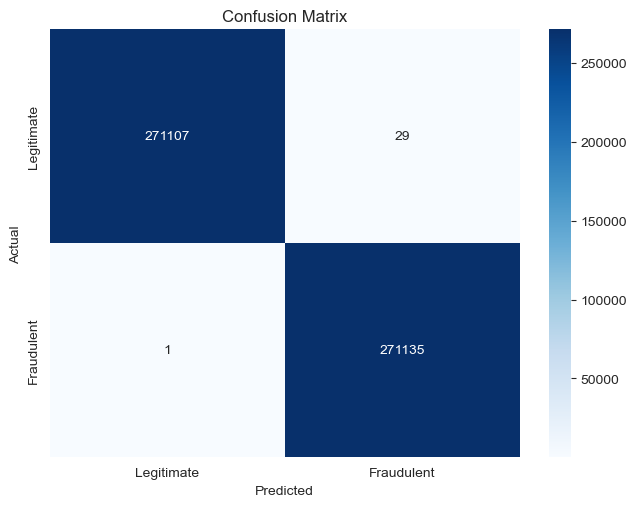

Duration: 1:25:51.629044


In [38]:
# Random Forest Classification, Stratified K-Fold Cross Validation (Post-Tuning)
# Runtime ~1.5h

dt_start = start_timing()
rfc = RandomForestClassifier(n_estimators = 900,
                             max_depth = 90,
                             max_features = 'auto',
                             min_samples_split = 5,
                             min_samples_leaf = 1,
                             bootstrap = False,
                             n_jobs = 10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(rfc, skf, X.to_numpy(), y.to_numpy())
print("Classification Report for Random Forest Classification (All Features, Post-Tuning)")
print("----------------------------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
plot_confusion_matrix(actual_classes, predicted_classes, class_labels)
show_duration(dt_start)


Start: 2023-02-20 11:32:07.339459


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [24:47<00:00, 297.56s/it]


Classification Report for Random Forest Classification (All Features, Post-Tuning)
----------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Legitimate     1.0000    0.9999    0.9999    271136
  Fraudulent     0.9999    1.0000    0.9999    271136

    accuracy                         0.9999    542272
   macro avg     0.9999    0.9999    0.9999    542272
weighted avg     0.9999    0.9999    0.9999    542272



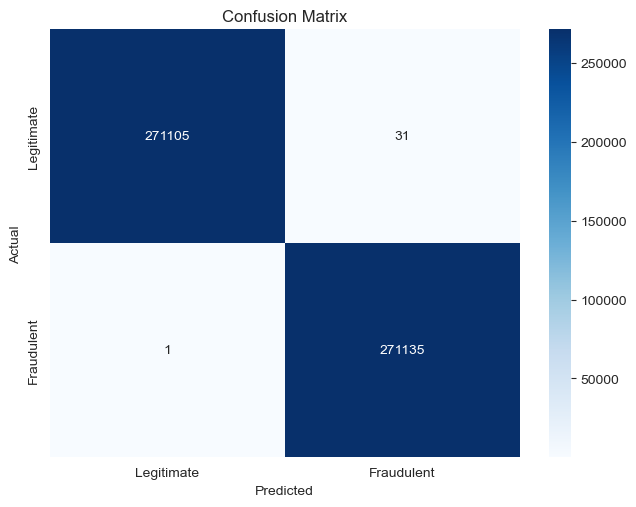

Duration: 0:24:48.476779


In [39]:
# Random Forest Classification, Stratified K-Fold Cross Validation (Post-Tuning)
# Runtime ~25m

dt_start = start_timing()
rfc = RandomForestClassifier(n_estimators = 260,
                             max_depth = 70,
                             max_features = 'sqrt',
                             min_samples_split = 2,
                             min_samples_leaf = 1,
                             bootstrap = False,
                             n_jobs = 10)
actual_classes, predicted_classes, predicted_proba = cross_val_predict(rfc, skf, X.to_numpy(), y.to_numpy())
print("Classification Report for Random Forest Classification (All Features, Post-Tuning)")
print("----------------------------------------------------------------------------------")
print(metrics.classification_report(actual_classes, predicted_classes, target_names=class_labels, digits=4))
plot_confusion_matrix(actual_classes, predicted_classes, class_labels)
show_duration(dt_start)

## Conclusion

<div style="text-align:justify">A point we have confirmed with the results above is that fraudulent transactions can be identified with a high degreee of confidence. However it will be difficult to recommend a model to deploy into production without knowing how the results will be used. For instance, is a prediction used as part of a weighted score to help the system make an automated decision to block a potentially fraudulent transaction? If so, we can deploy a logistic regression model that is quicker and less resource-intensive if the tolerance for error is high. On the other hand, if the prediction is the sole deciding factor to block a transaction, the random forest classifier model will probably be best suited to the task.</div>
<br/>

## Changelog
<table align='left'>
    <tr><td><b>Date</b></td><td><b>Update/s</b></td></tr>
    <tr><td>20-Feb-23</td><td>Initial version.</td></tr>
</table>
<br/>